# I) Summary

- The paper [Going Deeper with Convolutions][paper] introduces the first version of Inception model called GoogLeNet.


- During ILSVLC-2014, they achieved 1st place at the classification task (top-5 test error = 6.67%)


- It has around 6.7977 million parameters (without auxilaries layers) which is 9x fewer than AlexNet (ILSVRC-2012 winner) and 20x fewer than its competitor VGG-16.


- In most of the standard network architectures, the intuition is not clear why and when to perform the max-pooling operation, when to use the convolutional operation. For example, in AlextNet we have the convolutional operation and max-pooling operation following each other whereas in VGGNet, we have 3 convolutional operations in a row and then 1 max-pooling layer.


- Thus, **the idea behind GoogLeNet is to use all the operations at the same time**. It computes multiple kernels of different size over the same input map in parallel, concatenating their results into a single output. This is called an **Inception module**.

<div style="text-align: center">
    <img src="https://cdn.discordapp.com/attachments/676833120053493770/689776141221101629/unknown.png"
         height="100%" width="100%">
</div>

- Consider the following:

<div style="text-align: center">
    <img src="https://media.discordapp.net/attachments/676833120053493770/690136206092402715/unknown.png"
         height="50%" width="70%">
</div>
 

<div style="text-align: center">
    <img src="https://cdn.discordapp.com/attachments/676833120053493770/690138280058028146/unknown.png"
         height="50%" width="90%">
</div>


- The Naive approach is computationally expensive:
    - Computation cost = ((28 x 28 x 5 x 5) x 192) x 32 $\simeq$ **120 Mil**
        - We perform (28 x 28 x 5 x 5) operations along 192 channels for each of the 32 filters.


- The dimension reduction approach is **less** computationally expensive:
    - 1st layer computation cost = ((28 x 28 x 1 x 1) x 192) x 16 $\simeq$ 2.4 Mil
    - 2nd layer computation cost = ((28 x 28 x 5 x 5) x 16) x 32 $\simeq$ 10 Mil  
    - Total computation cost $\simeq$ **12.4 Mil**

---

Here its architecture:

<div style="text-align: center">
    <img src="https://cdn.discordapp.com/attachments/676833120053493770/690150147392667651/unknown.png"
         height="100%" width="100%">
</div>

- There are:
    - 9 Inception modules (red box)
    - Global Average pooling were used instead of a Fully-connected layer.
        - It enables adapting and fine-tuning on the network easily.
    - 2 auxilaries softmax layer (green box)
        - Their role is to push the network toward its goal and helps to ensure that the intermediate features are good enough for the network to learn.
        - It turns out that softmax0 and sofmax1 gives regularization effect.
        - During training, their loss gets added to the total loss with a discount weight (the losses of the auxiliary classifiers were weighted by 0.3).
        - During inference, they are discarded.
        - Structure:
            - Average pooling layer with 5×5 filter size and stride 3 resulting in an output size:
                - For 1st green box: 4x4x512.
                - For 2nd green box: 4x4x528.
            - 128 1x1 convolutions + ReLU.
            - Fully-connected layer with 1024 units + ReLU.
            - Dropout = 70%.
            - Linear layer (1000 classes) + Softmax.

<br>

<div style="text-align: center">
    <img src="https://cdn.discordapp.com/attachments/676833120053493770/690147584534511659/unknown.png"
         height="100%" width="80%">
</div>

<div style="text-align: center">
    <img src="https://cdn.discordapp.com/attachments/676833120053493770/690676447336988832/legend.png"
         height="100%" width="100%">
</div>

<div style="text-align: center">
    <img src="https://cdn.discordapp.com/attachments/676833120053493770/691604662268461056/unknown.png"
         height="100%" width="100%">
</div>

<div style="text-align: center">
    <img src="https://cdn.discordapp.com/attachments/676833120053493770/691591126502866944/unknown.png"
         height="100%" width="100%">
</div>

[paper]: https://arxiv.org/pdf/1409.4842.pdf

# II) Implementation

In [0]:
from utils import *

import numpy as np
import os
import cv2
import shutil
import urllib.request
import scipy.stats as stats
from collections import OrderedDict
from matplotlib import pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchsummary import summary

## a) Loading dataset / Preprocessing

In [0]:
def load_cifar():
    
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
            
    train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

    #Clear downloading message.
    clear_output()
    
    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, (45000, 5000))
    
    print("Image Shape: {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')
    print("Training Set:   {} samples".format(len(train_dataset)))
    print("Validation Set:   {} samples".format(len(val_dataset)))
    print("Test Set:       {} samples".format(len(test_dataset)))
    
    if torch.cuda.is_available():
      BATCH_SIZE = 4096
    else:
      BATCH_SIZE = 32

    # Create iterator.
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    
    # Delete the data/ folder.
    shutil.rmtree('./data')
    
    return train_loader, val_loader, test_loader

In [66]:
train_loader, val_loader, test_loader = load_cifar()

Image Shape: (3, 32, 32)

Training Set:   45000 samples
Validation Set:   5000 samples
Test Set:       10000 samples


In [0]:
def plot_example(X, y, y_pred=None):
    """
        Plots 9 examples and their associate labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    """
    classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
               5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
    
    # Create figure with 3 x 3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(10,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
     
    X, y = X[:9, 0, ...], y[:9] 
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(X[i])

        # Show true and predicted classes.
        if y_pred is None:
            xlabel = "True: {0}".format(classes[y[i]])
        else:
            xlabel = "True: {0}, Pred: {1}".format(classes[y[i]], classes[y_pred[i]])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

In [0]:
def plot_example_errors(X, y, y_pred):
    """
        Plots 9 example errors and their associate true/predicted labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    
    """
    incorrect = (y != y_pred)
 
    X = X[incorrect]
    y = y[incorrect]
    y_pred = y_pred[incorrect]

    # Plot the first 9 images.
    plot_example(X, y, y_pred)

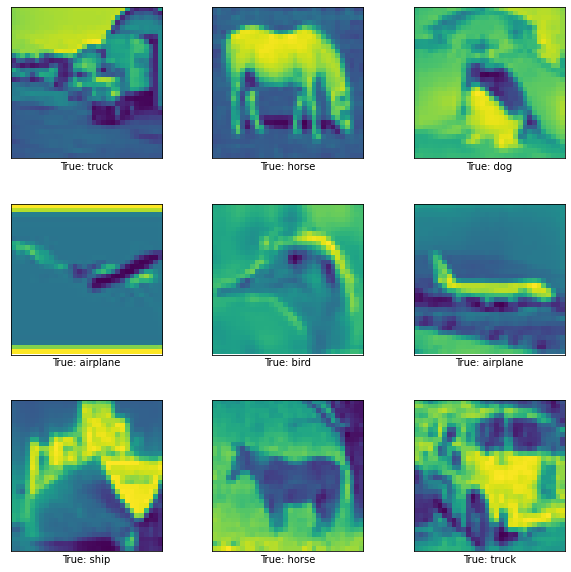

In [69]:
images, labels = iter(train_loader).next()
plot_example(images.numpy(), labels.numpy())

## b) Architecture build

- Local Response Normalization will be replaced by Batch Normalization.

In [0]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [0]:
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pp):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, f_3x3_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_3x3_r, f_3x3, kernel_size=3, stride=1, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, f_5x5_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_5x5_r, f_5x5, kernel_size=5, stride=1, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            ConvBlock(in_channels, f_pp, kernel_size=1, stride=1, padding=0)
        )
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [0]:
class InceptionAux(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.pool(x)
        
        x = self.conv(x)
        x = self.act(x)
    
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [0]:
class GoogLeNet(nn.Module):
    
    def __init__(self, isTraining, num_classes = 10, init_weights=True):
        super(GoogLeNet, self).__init__()
        
        self.isTraining = isTraining
        
        self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = ConvBlock(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception3A = InceptionModule(in_channels=192,
                                           f_1x1=64,
                                           f_3x3_r=96,
                                           f_3x3=128,
                                           f_5x5_r=16,
                                           f_5x5=32,
                                           f_pp=32)
        self.inception3B = InceptionModule(in_channels=256,
                                           f_1x1=128,
                                           f_3x3_r=128,
                                           f_3x3=192,
                                           f_5x5_r=32,
                                           f_5x5=96,
                                           f_pp=64)
        self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception4A = InceptionModule(in_channels=480,
                                           f_1x1=192,
                                           f_3x3_r=96,
                                           f_3x3=208,
                                           f_5x5_r=16,
                                           f_5x5=48,
                                           f_pp=64)
        self.inception4B = InceptionModule(in_channels=512,
                                           f_1x1=160,
                                           f_3x3_r=112,
                                           f_3x3=224,
                                           f_5x5_r=24,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4C = InceptionModule(in_channels=512,
                                           f_1x1=128,
                                           f_3x3_r=128,
                                           f_3x3=256,
                                           f_5x5_r=24,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4D = InceptionModule(in_channels=512,
                                           f_1x1=112,
                                           f_3x3_r=144,
                                           f_3x3=288,
                                           f_5x5_r=32,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4E = InceptionModule(in_channels=528,
                                           f_1x1=256,
                                           f_3x3_r=160,
                                           f_3x3=320,
                                           f_5x5_r=32,
                                           f_5x5=128,
                                           f_pp=128)
        self.pool5 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception5A = InceptionModule(in_channels=832,
                                           f_1x1=256,
                                           f_3x3_r=160,
                                           f_3x3=320,
                                           f_5x5_r=32,
                                           f_5x5=128,
                                           f_pp=128)
        self.inception5B = InceptionModule(in_channels=832,
                                           f_1x1=384,
                                           f_3x3_r=192,
                                           f_3x3=384,
                                           f_5x5_r=48,
                                           f_5x5=128,
                                           f_pp=128)
        self.pool6 = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        
        if self.isTraining:   
            self.aux4A = InceptionAux(512, num_classes) 
            self.aux4D = InceptionAux(528, num_classes)
        
        if init_weights:
            self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                X = stats.truncnorm(-2, 2, scale=0.01)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.inception3A(x)
        x = self.inception3B(x)
        x = self.pool4(x)
        x = self.inception4A(x)
        
        if self.isTraining:
            aux1 = self.aux4A(x)
        
        x = self.inception4B(x)
        x = self.inception4C(x)
        x = self.inception4D(x)
        
        if self.isTraining:
            aux2 = self.aux4D(x)
        
        x = self.inception4E(x)
        x = self.pool5(x)
        x = self.inception5A(x)
        x = self.inception5B(x)
        x = self.pool6(x)
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = self.fc(x)
        
        if self.isTraining:
            return x, aux1, aux2
        else:
            return x

In [0]:
model = GoogLeNet(isTraining=True)

In [75]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         ConvBlock-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]           4,160
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
         ConvBlock-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 192, 8, 8]         110,784
      BatchNorm2d-11            [-1, 192, 8, 8]             384
             ReLU-12            [-1, 192, 8, 8]               0
        ConvBlock-13            [-1, 192, 8, 8]               0
        MaxPool2d-14            [-1, 19

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## c) Training the model

In [0]:
def train_model():
    EPOCHS = 20
    nb_examples = 45000
    nb_val_examples = 5000
    train_costs, val_costs = [], []
    
    #Training phase.
    
    for epoch in range(EPOCHS):

        train_loss = 0
        correct_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            prediction0, prediction1, prediction2 = model(inputs)
            
            # Compute the loss.
            loss0 = criterion(prediction0, labels)
            loss1 = criterion(prediction1, labels)
            loss2 = criterion(prediction2, labels)
            
            loss = loss0 + 0.3 * loss1 + 0.3 * loss2
            
            # Backward pass.
            loss.backward()
            
            # Optimize.
            optimizer.step()
            
            # Compute training accuracy.
            _, predicted = torch.max(prediction0.data, 1)
            correct_train += (predicted == labels).sum().item()
            
            # Compute batch loss.
            train_loss += (loss.data.item() * inputs.shape[0])


        train_loss /= nb_examples
        train_costs.append(train_loss)
        train_acc =  correct_train / nb_examples

        val_loss = 0
        correct_val = 0

        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            prediction0, prediction1, prediction2 = model(inputs)
            
            # Compute the loss.
            loss0 = criterion(prediction0, labels)
            loss1 = criterion(prediction1, labels)
            loss2 = criterion(prediction2, labels)
            
            loss = loss0 + 0.3 * loss1 + 0.3 * loss2
            
            # Backward pass.
            loss.backward()
            
            # Optimize.
            optimizer.step()
            
            # Compute training accuracy.
            _, predicted = torch.max(prediction0.data, 1)
            correct_val += (predicted == labels).sum().item()
            
             # Compute batch loss.
            val_loss += (loss.data.item() * inputs.shape[0])

        val_loss /= nb_val_examples
        val_costs.append(val_loss)
        val_acc =  correct_val / nb_val_examples
        
        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f} | val-loss = {:0.6f} | val-acc = {:0.3f}"
        print(info.format(epoch+1, EPOCHS, train_loss, train_acc, val_loss, val_acc))
        torch.save(model.state_dict(), 'save_weights/googlenet_model_{}'.format(epoch + 1)) 
                                                                
    torch.save(model.state_dict(), 'googlenet_model_final')  
        
    return train_costs, val_costs

In [78]:
train_costs, val_costs = train_model()

[Epoch 1/20]: train-loss = 3.337094 | train-acc = 0.220 | val-loss = 2.802224 | val-acc = 0.325
[Epoch 2/20]: train-loss = 2.557571 | train-acc = 0.387 | val-loss = 2.335853 | val-acc = 0.440
[Epoch 3/20]: train-loss = 2.191851 | train-acc = 0.489 | val-loss = 1.969647 | val-acc = 0.549
[Epoch 4/20]: train-loss = 1.932995 | train-acc = 0.556 | val-loss = 1.746358 | val-acc = 0.605
[Epoch 5/20]: train-loss = 1.729847 | train-acc = 0.611 | val-loss = 1.530364 | val-acc = 0.658
[Epoch 6/20]: train-loss = 1.507906 | train-acc = 0.665 | val-loss = 1.297369 | val-acc = 0.717
[Epoch 7/20]: train-loss = 1.319329 | train-acc = 0.711 | val-loss = 1.151064 | val-acc = 0.749
[Epoch 8/20]: train-loss = 1.223894 | train-acc = 0.732 | val-loss = 0.997665 | val-acc = 0.787
[Epoch 9/20]: train-loss = 1.069085 | train-acc = 0.766 | val-loss = 0.834602 | val-acc = 0.821
[Epoch 10/20]: train-loss = 0.989535 | train-acc = 0.784 | val-loss = 0.746914 | val-acc = 0.845
[Epoch 11/20]: train-loss = 0.828136 | 

## d) Evaluating model

In [81]:
# Restore the model.
model = GoogLeNet(isTraining=False)
load_model('googlenet_model_final', model)

IndexError: ignored

In [0]:
# Create iterator.
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Make predictions.
predictions = model(images)

# Retrieve predictions indexes.
_, predicted = torch.max(predictions, 1)

# Compute number of correct predictions.
correct = (predicted == labels).sum().item()

# Compute accuracy on test set.
test_accuracy = correct / images.shape[0]
print('Test set error rate: {}'.format(test_accuracy))

# Plot some examples with model predictions.
print('\nSome correct classification:')
plot_example(images.numpy(), labels.numpy(), predicted.numpy())

print('\nSome incorrect classification:')
plot_example_errors(images.numpy(), labels.numpy(), predicted.numpy())

# Plot training error.
print('\nPlot of training/validation error over 20 epochs:')
plt.title('Training/Validation error')
plt.ylabel('Cost')
plt.xlabel('epoch')

plt.plot(train_costs)
plt.plot(val_costs)
plt.legend(['train-loss', 'val-loss'], loc='upper right')
plt.show()